## Denoising and Detoning

### 1. Motivation

공분산 행렬은 금융 어디에서나 존재한다. 경험적 공분산 행렬은 랜덤 벡터를 구성하는 랜덤 변수 사이의 선형 결합을 추정하고자 랜덤 벡터의 일련의 관측값에 대해 계산된다. 이러한 관측값의 유한성과 비결정론적 특성을 고려할 때 공분산 행렬의 추정값에는 일정량의 잡음이 포함되어 있다

금융시장 분석에 있어서 factor들은 이러한 불안정한 공분산으로부터 추정되었기 떄문에 추정된 공분산은 필연적으로 불량 조건 하에 있게 된다. 이 잡음을 처리하지 않는 한 공분산 행렬로 수행하는 계산에 영향을 미칠 수 있으며, 때로는 분석을 무용지물로 만들 수도 있다

이번 장에서는 공분산 행렬에서의 잡음을 줄이고, 경험적 공분산 행렬에 포함된 신호를 개선하도록 한다

### 2. The Marcenko-Pastur Theorem

관측값을 생성하는 기본 프로세스의 평균 0과 분산 $\sigma^2$인 독립적이고 동일하게 분포된 랜덤 관측값 X의 행렬을 고려하자. 행렬 $C = T^{-1}X^\prime X$는 Marcenko-Pastur Probability Density Function으로 점근적으로 수렴하는 고유값을 가진다

$$f(\lambda) = \begin{cases}
\frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2 \pi \lambda \sigma^2}, & \mbox{     if }\lambda \in [\lambda_-, \lambda_+] \\
0, & \mbox{     if }\lambda \notin [\lambda_-, \lambda_+]
\end{cases}$$

여기서 최대 기대 고유값은 $\lambda_+ = \sigma^2(1 + \sqrt{N/T})^2$이고, 최소 기대 고유값은 $\lambda_- = \sigma^2 (1-\sqrt{N/T})^2$이다. $\sigma^2 = 1$일 때 $C$는 $X$와 연관된 상관 행렬이다. 

아래와 같이 Marcenko-Pastur 분포가 Random Matrix의 고유값을 얼마나 근접하게 설명하는지 보여 준다

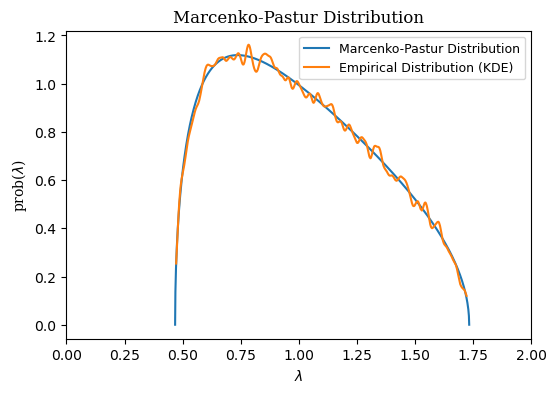

In [1]:
%run MarcenkoPastur.py

#### 3. Random Matrix with Signal

경험적 상관 행렬에서 모든 고유 벡터가 랜덤하지 않을 수 있다 (사실 대부분의 경우에서 고유 벡터는 랜덤하지 않을 것이다)

대부분의 금융시장에서는 신호는 약하고, 잡음은 굉장이 클 것이다. 랜덤 공분산 행렬에 신호를 추가하여 비교해 보자

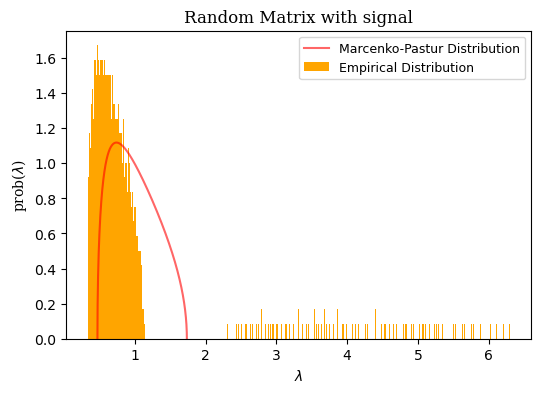

In [2]:
%run RandomMatrixWithSignal.py

고유값이 2가 넘어가는 부분이 signal, 이하 분포는 잡음이다. 랜덤 공분산 행렬에 비해서 분포 자체는 왼쪽으로 치중되어 있고 signal에 대한 고유값은 오른쪽에 분포되어 있다

#### 4. Fitting the Marcenko–Pastur Distribution

분산의 일부만이 랜덤 고유 벡터에 의해 야기되기 때문에 변동성 $\sigma^2$를 $\sigma^2(1 - \lambda_+/N)$등으로 대체할 수 있다. 실제로 $f(\lambda)$라는 함수를 고유값의 경험적 분포에 적합화하여 내재 변동성을 도출할 수 있다

이런 식으로 상관계수 행렬의 랜덤 고유 벡터로 설명되는 분산을 얻을 수 있고, 도출된 분산으로 랜덤이 아닌 고유벡터의 존재를 고려한 significance level $\lambda_+$를 결정할 수 있다

sse:741.3636812172272
sse:741.3635870518854
sse:290.33166423761736
sse:290.33165994757115
sse:280.39171028842793
sse:280.391715117128
sse:227.10021234567654
sse:227.10022022431502
sse:413.4041853396672
sse:413.4041224374838
sse:68.03819906629214
sse:68.0382106823929
sse:18.795426400207692
sse:18.7954285321798
sse:3142.3534758441397
sse:3142.353159176346
sse:23.16829542401525
sse:23.168288766016165
sse:18.14988136422722
sse:18.149881425946013
sse:18.149370297588113
sse:18.14937029487853
sse:18.149369310884726
sse:18.14936931088804
sse:18.14936931088505
sse:18.14936931088495
sse:18.149369310884527
sse:18.149369310886936
found errPDFs0.6762918982669632


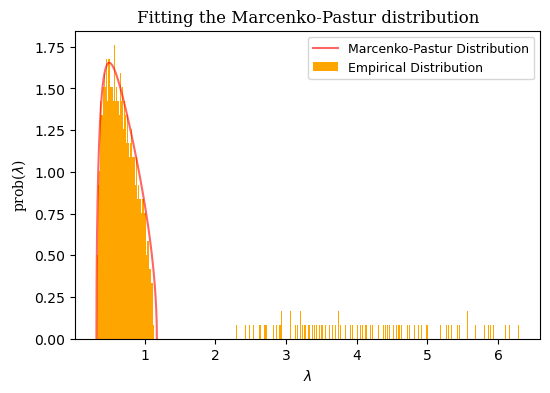

In [3]:
%run FittingMarcenkoPastur.py

적합화된 분산의 약 32.32%만이 신호에서 기인함을 볼 수 있으며, 이 절차를 통해 잡음과 관련된 고유값을 신호와 관련된 고유값에서 분리할 수 있었다

#### 5. Denoising

empirical finance에서 대부분의 경우 공분산을 축소하여 사용하는 것이 일반적이다. 그러나 차원의 축소는 잡음 뿐만 아니라 신호 또한 구분하지 않고 조건의 수를 감소시킨다. 안그래도 약한 신호를 축소를 통해 더욱 약하게 만들 수도 있다

이번 절에서는 상관 행렬의 잡음 제거에 이 정보를 사용하는 방법에 대해 논한다

**5.1 Constant Residual Eigenvalue Method**

이 접근 방식은 모든 랜덤 고유 벡터에 대해 상수 고유값을 설정하는데에 있다. $\{\lambda_n\}_{n=1, \dots, N}$은 모든 고유값의 집합이며, 내림차순이며, $i$는 $\lambda_i > \lambda_+$와 $\lambda_{i+1} \leq \lambda_+$가 되는 고유값의 위치가 된다. 그런 다음 $\lambda_j = frac{1}{N-i} \sum_{k = i+1}^N \lambda_k, j = i+1, \dots, N$을 설정해 상관 행렬의 대각합을 보존한다. 고유 벡터 분해 $VW = W\Lambda$가 주어질 때 다음과 같이 잡음이 제거된 상관행렬 $C_1$을 형성한다

$$\tilde C_1 = W \tilde\Lambda W^\prime$$
$$C_1 = \tilde C_1\Big[ \big(\mbox{diag}[\tilde C_1]\big)^\frac{1}{2}
\big(\mbox{diag}[\tilde C_1]\big)^{\frac{1}{2} \prime}\Big]^{-1}$$

sse:746.7661515735786
sse:746.7660571129732
sse:289.8634561307734
sse:289.8634521313219
sse:281.2641288979943
sse:281.26413335618975
sse:231.8002496930494
sse:231.80025752674487
sse:251.8157256256318
sse:251.8156802293903
sse:46.193091611250104
sse:46.193101985961064
sse:18.822895240718594
sse:18.82289744150866
sse:6587.1048556131545
sse:6587.104194109297
sse:90.46624420065348
sse:90.4662196413688
sse:18.159777826265042
sse:18.159778279343236
sse:18.13208150639543
sse:18.13208148314063
sse:18.132009317406613
sse:18.1320093176288
sse:18.13200931092128
sse:18.132009310921404
found errPDFs0.6766189450215223


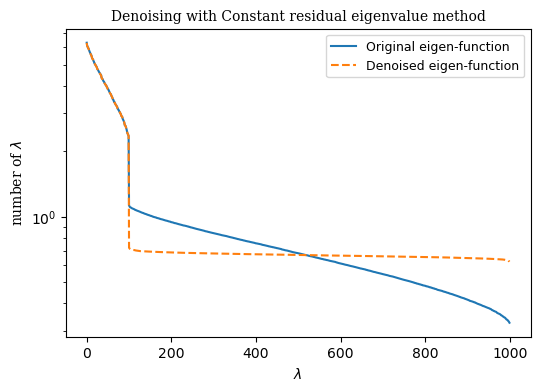

In [4]:
%run ConstantResidual.py

**5.2 Targeted Shrinkage**

5.1에서 설명한 수치적 방법은 신호를 보존하면서 잡음을 제거하기 때문에 축소보다는 선호된다. 대안적으로 랜덤 고유 벡터에 대해 엄격한 축소 적용을 목표로 할 수도 있다. 다음의 상관 행렬 $C_1$을 고려하자

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from RandomMatrixWithSignal import cov2corr, getRndCov
from MarcenkoPastur import getPCA
from FittingMarcenkoPastur import findMaxEval
from ConstantResidual import denoisedCorr2

alpha, nCols, nFact, q = 0.995, 1000, 100, 10

cov = np.cov(np.random.normal(size = (nCols * q, nCols)), rowvar = 0)
cov = alpha * cov + (1-alpha) * getRndCov(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

sse:743.1670228793666
sse:743.1669289017266
sse:291.6648126112168
sse:291.6648087737076
sse:283.4312180962904
sse:283.4312226938057
sse:234.92561682641903
sse:234.92562426558567
sse:190.0959664335643
sse:190.09592939157645
sse:190.5780897049453
sse:190.57809915187624
sse:20.06150483595796
sse:20.061508353472075
sse:18.261605492369707
sse:18.26160611136644
sse:98.74950703508992
sse:98.74948095101789
sse:18.21125550579433
sse:18.21125562923395
sse:18.20920010567772
sse:18.209200104087156
sse:18.209199764668767
sse:18.20919976467264
sse:18.209199764668604
sse:18.209199764668607
found errPDFs0.6765254471943923


In [3]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 0.5)
eVal1, eVec1 = getPCA(corr1)

denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

Text(0.5, 1.0, 'Denoising with Constant residual eigenvalue method')

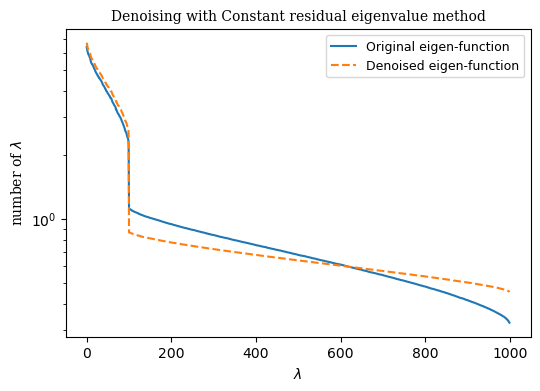

In [4]:
plt.figure(figsize = (6,4))
plt.plot(eigenvalue_prior, label = 'Original eigen-function')
plt.plot(denoised_eigenvalue, label = 'Denoised eigen-function', ls = '--')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontfamily='Serif')
plt.ylabel(r'number of $\lambda$', fontfamily='Serif')
plt.legend(loc='upper right', fontsize=9)
plt.title('Denoising with Targeted Shrinkage', fontsize=10, fontfamily='Serif')